# Land Cover Classification using Deep Learning for EuroSAT

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm
import seaborn as sns
from datetime import datetime

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

In [2]:
# If I need to combine contenets of several folder
'''
import shutil
from distutils.dir_util import copy_tree
destination_folder = "/home/dock/Eurosat/allData"
os.makedirs(destination_folder, exist_ok=True)
def get_subfolder_names_with_walk(folder_path):
    subfolder_names = []
    for root, subfolder_names, files in os.walk(folder_path):
        # 'dirs' is a list of subfolders in the current directory
        subfolder_names = [name for name in subfolder_names if '.' not in name]
        for Subfolder in subfolder_names:
            copy_tree(os.path.join(folder_path,Subfolder), destination_folder)

folder_path = '/home/dock/Eurosat/EuroSAT'
source_folder_contents = os.listdir(folder_path)
subfolder_names = get_subfolder_names_with_walk(folder_path)
'''

'\nimport shutil\nfrom distutils.dir_util import copy_tree\ndestination_folder = "/home/dock/Eurosat/allData"\nos.makedirs(destination_folder, exist_ok=True)\ndef get_subfolder_names_with_walk(folder_path):\n    subfolder_names = []\n    for root, subfolder_names, files in os.walk(folder_path):\n        # \'dirs\' is a list of subfolders in the current directory\n        subfolder_names = [name for name in subfolder_names if \'.\' not in name]\n        for Subfolder in subfolder_names:\n            copy_tree(os.path.join(folder_path,Subfolder), destination_folder)\n\nfolder_path = \'/home/dock/Eurosat/EuroSAT\'\nsource_folder_contents = os.listdir(folder_path)\nsubfolder_names = get_subfolder_names_with_walk(folder_path)\n'

## Config

In [3]:
ROOT_PATH = '/home/dock/Eurosat/'
DATA_PATH = "/home/dock/Eurosat/allData"
BASE_PATH = DATA_PATH #os.path.join(ROOT_PATH, 'allBands')

FULL_DATA_DF = os.path.join(ROOT_PATH, 'train.csv')
val_DATA_DF = os.path.join(ROOT_PATH, 'val.csv')
Test_DATA_DF = os.path.join(ROOT_PATH, 'test.csv')

if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1


## Utils

In [4]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target


In [5]:
## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


## Pre-Processing data folders to train and test


In [6]:
# Run this code cells only if you don't have the required dataframe
from os import walk

i = 0
DATA_DF = pd.DataFrame(columns = ['image_id', 'label']) 

for (dirpath, dirname, filename) in walk(BASE_PATH):
   for each_file in filename:
     DATA_DF.loc[i] = [each_file, each_file.split('_')[0]]
     i += 1
DATA_DF.to_csv(FULL_DATA_DF, index=False)
DATA_DF.head()

,image_id,label
0,Highway_1385.jpg,Highway
1,Highway_809.jpg,Highway
2,AnnualCrop_2326.jpg,AnnualCrop
3,Residential_2933.jpg,Residential
4,Forest_1293.jpg,Forest


In [7]:
# from os import walk
# i = 0
# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   print("Directory Path: ", dirpath)
#   print("Directory Name: ", dirname)
#   print("Filename : ", filename)
#   print("----------------------"*10)
#   i += 1
#   if i > 3:
#     break

## Processing data folders to train and test


In [8]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) #sample method in pandas to shuffle the rows of the DataFrame
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

In [9]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,image_id,label
0,19127,Residential_794.jpg,Residential
1,3197,HerbaceousVegetation_675.jpg,HerbaceousVegetation
2,24557,SeaLake_1026.jpg,SeaLake
3,17042,SeaLake_1309.jpg,SeaLake
4,3697,Highway_1944.jpg,Highway


In [10]:
VALID_DF.reset_index(inplace = True) 
VALID_DF.head()

,index,image_id,label
0,21985,Residential_1817.jpg,Residential
1,25621,PermanentCrop_1468.jpg,PermanentCrop
2,21573,SeaLake_156.jpg,SeaLake
3,25070,HerbaceousVegetation_1988.jpg,HerbaceousVegetation
4,13947,PermanentCrop_1701.jpg,PermanentCrop


In [11]:
TRAIN_DF.size, VALID_DF.size

(72900, 8100)

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [12]:
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [13]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSAT(VALID_DF, BASE_PATH, data_transform)
print(len(train_ds), len(valid_ds))

24300 2700


In [14]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [15]:
'''
for batch_idx, (inputs, targets) in enumerate(train_dl):
     print(f"Batch {batch_idx + 1} - Input Shape: {inputs.shape}, Target Shape: {targets.shape}")
    # import matplotlib.pyplot as plt
     for i in range(inputs.size(0)):
         plt.imshow(inputs[i].permute(1, 2, 0).numpy())
         plt.title(f"Target: {targets[i].item()}")
         plt.show()

    # Break the loop after a few batches for demonstration purposes
     if batch_idx == 2:
        break
'''

'\nfor batch_idx, (inputs, targets) in enumerate(train_dl):\n     print(f"Batch {batch_idx + 1} - Input Shape: {inputs.shape}, Target Shape: {targets.shape}")\n    # import matplotlib.pyplot as plt\n     for i in range(inputs.size(0)):\n         plt.imshow(inputs[i].permute(1, 2, 0).numpy())\n         plt.title(f"Target: {targets[i].item()}")\n         plt.show()\n\n    # Break the loop after a few batches for demonstration purposes\n     if batch_idx == 2:\n        break\n'

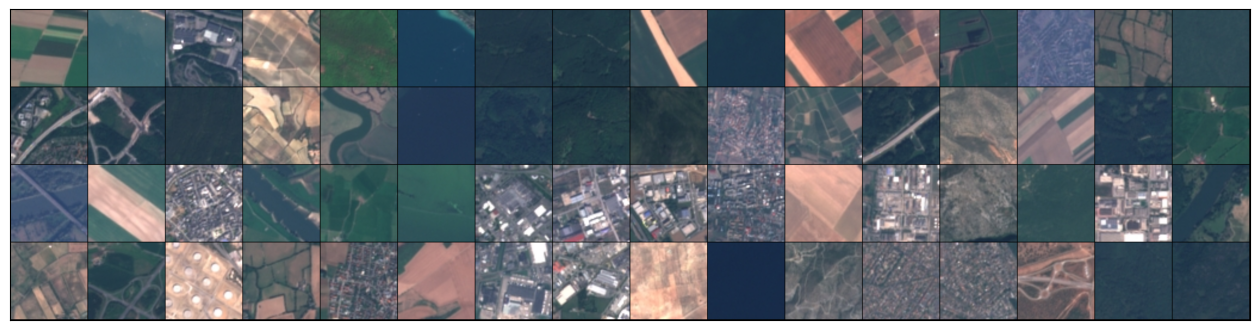

In [16]:
## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

## Model

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=True)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [19]:
model = LULC_Model()

/home/dock/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dock/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)

torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.3944, -2.3978, -2.4171, -2.2306, -2.3318, -2.0411, -2.3448, -2.5085,
        -2.1957, -2.2476], grad_fn=<SelectBackward0>)


## Training and Evaluating

In [21]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
    
    date = datetime.now().__str__()
    date = date[:16].replace(':', '-').replace(' ', '-')
    history = []
    valid_loss_min = np.Inf
    valid_acc_max = 0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        for batch in tqdm(train_loader):
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), f'lulc-{date}.pth') #model_file_name2
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

 Initializing Device also Loading Data and Model to device¶


In [22]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [23]:
device = get_device()

train_dl = DeviceDataLoader(train_dl, device) ## Loading data to devide
valid_dl = DeviceDataLoader(valid_dl, device)

model = to_device(LULC_Model(), device) ## Loading model to device
## lets try passing a batch to model again
try_batch(train_dl)

True
torch.Size([64, 3, 224, 224])
torch.Size([64, 10])
tensor([-2.2526, -2.2380, -2.1619, -2.2784, -2.2100, -2.1547, -2.6138, -2.2892,
        -2.6482, -2.3061], device='cuda:0', grad_fn=<SelectBackward0>)


In [24]:
torch.cuda.empty_cache()

## Training

In [25]:
## Hyper Parameters
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
epochs = 10
opt_func = torch.optim.Adam
evaluate(model, valid_dl) # Evaluating with non-trained model

{'val_loss': 2.306828260421753, 'val_acc': 0.09617248922586441}

In [26]:
#model.freeze() # Freezing except last layer
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [0],train_accu: 0.9225, learning_rate: 0.0001, train_loss: 0.2931, val_loss: 0.0792, val_acc: 0.9738


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [1],train_accu: 0.9667, learning_rate: 0.0001, train_loss: 0.1099, val_loss: 0.1070, val_acc: 0.9632


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [2],train_accu: 0.9710, learning_rate: 0.0001, train_loss: 0.0935, val_loss: 0.2083, val_acc: 0.9359


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [3],train_accu: 0.9755, learning_rate: 0.0001, train_loss: 0.0828, val_loss: 0.0858, val_acc: 0.9724


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [4],train_accu: 0.9834, learning_rate: 0.0000, train_loss: 0.0570, val_loss: 0.0829, val_acc: 0.9760


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [5],train_accu: 0.9848, learning_rate: 0.0000, train_loss: 0.0518, val_loss: 0.0812, val_acc: 0.9767


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [6],train_accu: 0.9837, learning_rate: 0.0000, train_loss: 0.0544, val_loss: 0.0799, val_acc: 0.9757


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [7],train_accu: 0.9844, learning_rate: 0.0000, train_loss: 0.0543, val_loss: 0.0839, val_acc: 0.9764


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [8],train_accu: 0.9838, learning_rate: 0.0000, train_loss: 0.0575, val_loss: 0.0837, val_acc: 0.9757


  0%|          | 0/380 [00:00<?, ?it/s]

Epoch [9],train_accu: 0.9840, learning_rate: 0.0000, train_loss: 0.0557, val_loss: 0.0805, val_acc: 0.9767
VAL LOSS MIN 0.07921803742647171
VAL ACC MAX 0.9767441749572754


### Training Reports

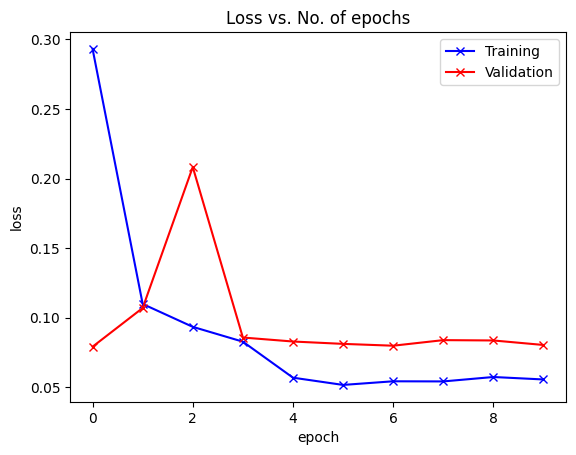

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

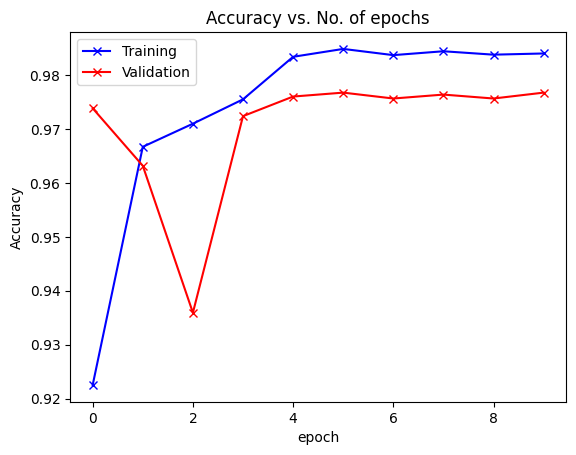

In [28]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

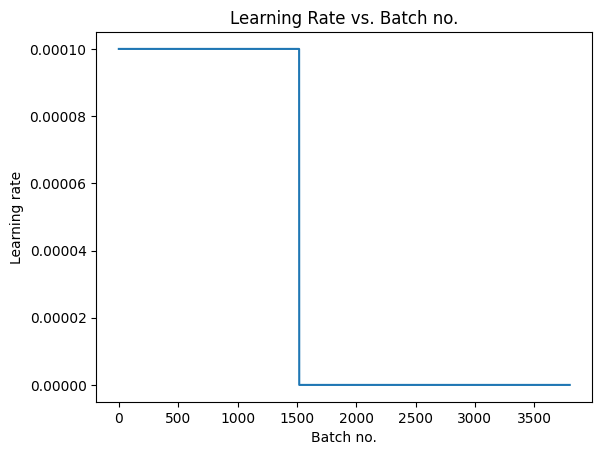

In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

### Prediction Reports

In [30]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)


In [34]:
print(valid_ds[1])

(tensor([[[0.5333, 0.5333, 0.5333,  ..., 0.5137, 0.5137, 0.5137],
         [0.5333, 0.5333, 0.5333,  ..., 0.5137, 0.5137, 0.5137],
         [0.5333, 0.5333, 0.5333,  ..., 0.5137, 0.5137, 0.5137],
         ...,
         [0.2118, 0.2118, 0.2118,  ..., 0.7373, 0.7569, 0.7569],
         [0.2118, 0.2118, 0.2118,  ..., 0.7412, 0.7608, 0.7608],
         [0.2118, 0.2118, 0.2118,  ..., 0.7412, 0.7608, 0.7608]],

        [[0.5020, 0.5020, 0.5020,  ..., 0.4784, 0.4784, 0.4784],
         [0.5020, 0.5020, 0.5020,  ..., 0.4784, 0.4784, 0.4784],
         [0.5020, 0.5020, 0.5020,  ..., 0.4784, 0.4784, 0.4784],
         ...,
         [0.3098, 0.3098, 0.3098,  ..., 0.6000, 0.6196, 0.6196],
         [0.3098, 0.3098, 0.3098,  ..., 0.6039, 0.6196, 0.6196],
         [0.3098, 0.3098, 0.3098,  ..., 0.6039, 0.6196, 0.6196]],

        [[0.4902, 0.4902, 0.4902,  ..., 0.4510, 0.4510, 0.4510],
         [0.4902, 0.4902, 0.4902,  ..., 0.4510, 0.4510, 0.4510],
         [0.4902, 0.4902, 0.4902,  ..., 0.4510, 0.4510, 0

'Highway'

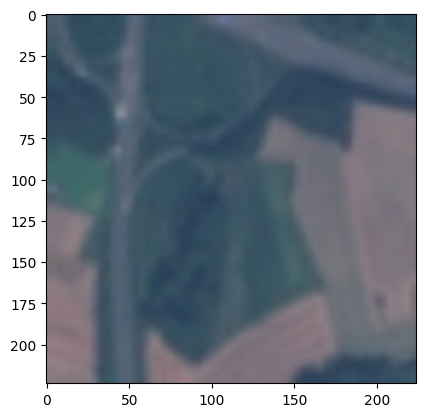

In [31]:
predict_single(valid_ds[40][0])

'Highway'

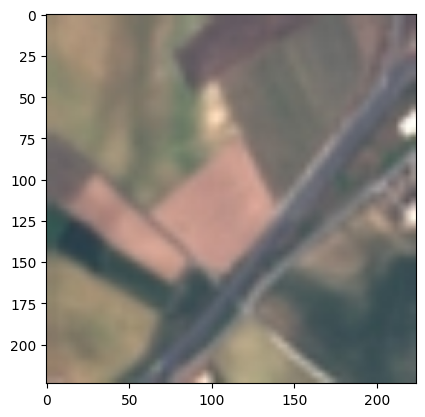

In [32]:
predict_single(valid_ds[30][0])

'Residential'

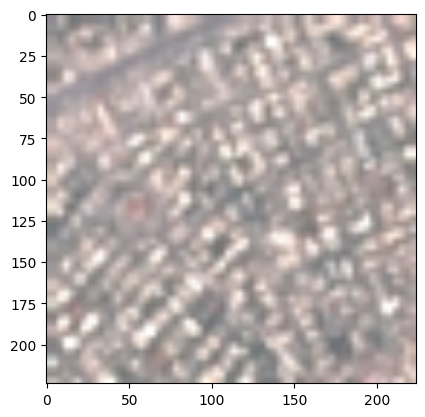

In [33]:
predict_single(valid_ds[10][0])

# Evaluation on whole dataset

In [13]:
batch_size =1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [35]:

## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [36]:
full_ds = EuroSAT(DATA_DF, BASE_PATH, data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to devide
full_dl = DeviceDataLoader(full_dl, device)


True


In [37]:
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/27000 [00:00<?, ?it/s]

0.9904074074074074


array([[2976,    1,    1,    2,    0,   17,   10,    0,    0,    0],
       [   0, 2981,    1,    1,    0,    1,    0,    0,    0,    0],
       [   4,    1, 2976,    2,    0,   22,   18,    1,    1,    0],
       [   1,    0,    0, 2409,    2,    1,    2,    0,    3,    0],
       [   0,    0,    0,    4, 2496,    0,    4,    1,    0,    0],
       [   1,    8,    2,    4,    0, 1951,    0,    0,    1,    0],
       [   5,    7,   14,    0,    0,    4, 2466,    0,    1,    0],
       [   0,    0,    1,    0,    1,    0,    0, 2997,    0,    0],
       [   2,    1,    3,   78,    1,    1,    0,    1, 2492,    3],
       [  11,    1,    2,    0,    0,    3,    0,    0,    2, 2997]])

In [38]:
current_directory = os.getcwd()
print(current_directory)

/home/dock/Eurosat


<Axes: >

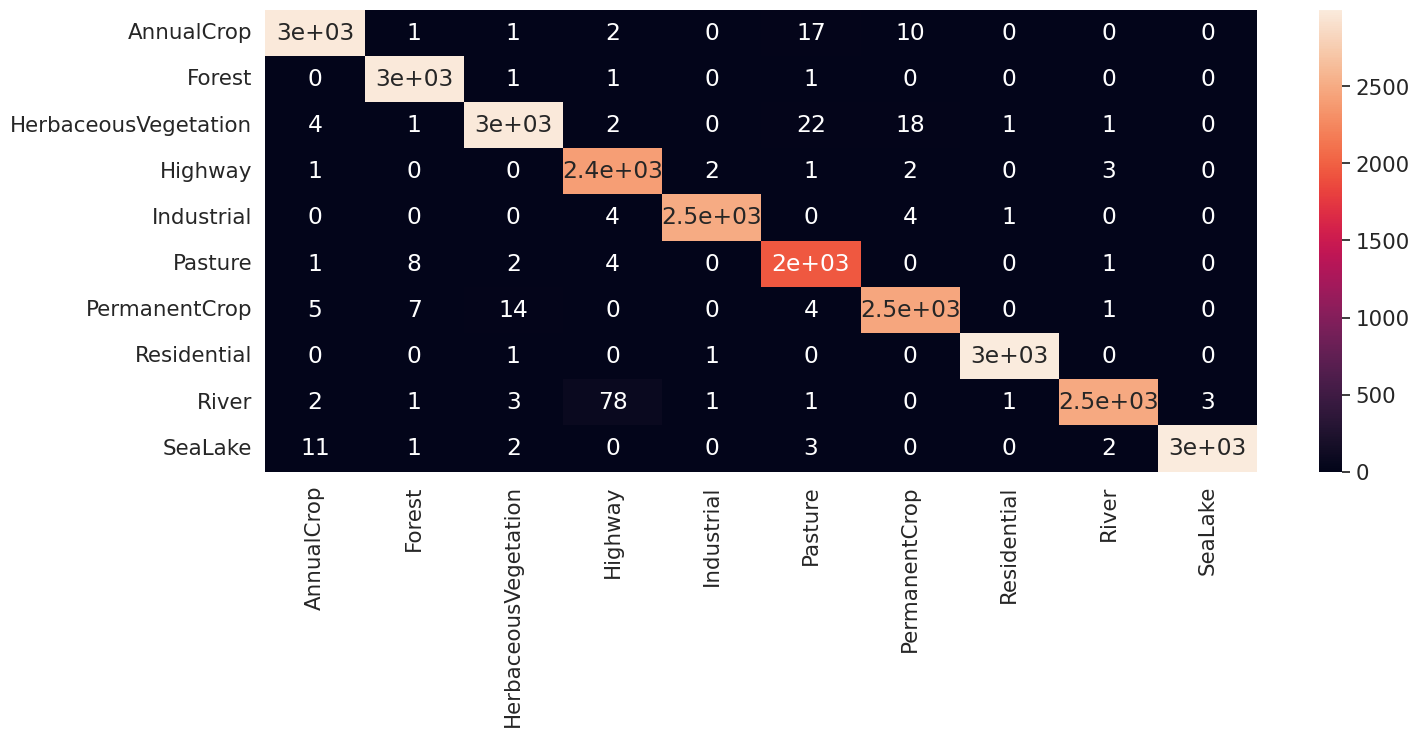

In [39]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

In [14]:
## Evaluation with best validation accuracy model
device = get_device()
model = LULC_Model()
model.load_state_dict(torch.load('/home/dock/Eurosat/lulc-2024-01-16-14-43.pt'))
model.eval()
model = to_device(model, device)
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

True


NameError: name 'full_dl' is not defined

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
sns.set(font_scale=1.4) # for label size
plt.figure(figsize = (16,6))
sns.heatmap(df_cm, annot=True)

Evalution of urban_positives_Italy

In [17]:
class urban_positives_Data(Dataset):
    def __init__(self, test_dir, test_transform):
        self.test_dir = test_dir
        self.path_image_list = self.get_image_list()
        self.transform = test_transform
        
    def __len__(self):
        return len(self.path_image_list)
    
    def __getitem__(self, idx):
        filepath = self.path_image_list[idx]
        print(filepath)
        img = self.load_pil_image(filepath)
        img = self.transform(img)
        #img =  transforms.ToPILImage(img)
        #img = transforms.ToTensor(img)
        return img

    def get_image_list(self):
        image_list = []
        for file in os.listdir(self.test_dir):
            if not file.startswith('.') and file.lower().endswith('.png'):
               print(file)
               path = os.path.join(self.test_dir, file)
               image_list.append(path)
        return image_list

    def load_pil_image(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            plt.imshow(img)
            plt.show()
            return img.convert('RGB')

In [18]:
Data_path_UP = '/home/dock/urban_positives/1241'
data_transform = transforms.Compose([
                                transforms.Resize(size=(128, 128)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
test_ds = urban_positives_Data(Data_path_UP, data_transform)

2015.png
2019.png
2022.png
2009.png
2023.png


In [19]:
batch_size =1
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
test_dl = DeviceDataLoader(test_dl, device)
print(len(test_dl))

True
5


In [20]:
def show_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=6).permute(1, 2, 0))
        break
#show_batch(test_dl)

In [34]:
@torch.no_grad()
def predict_dl_test(dl, model):
    torch.cuda.empty_cache()
    batch_pred = []
    for xb in tqdm(dl):
        #print(xb)
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())      
    return [x for x in batch_pred]

True


  0%|          | 0/5 [00:00<?, ?it/s]

/home/dock/urban_positives/1241/2022.png


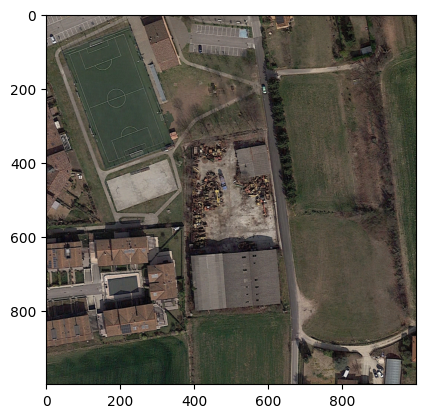

/home/dock/urban_positives/1241/2009.png


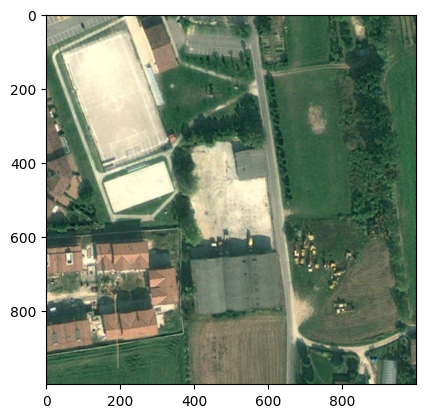

/home/dock/urban_positives/1241/2019.png


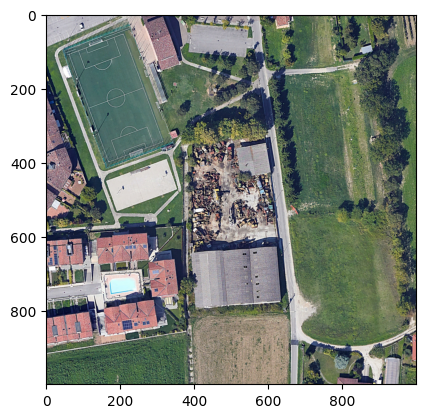

/home/dock/urban_positives/1241/2023.png


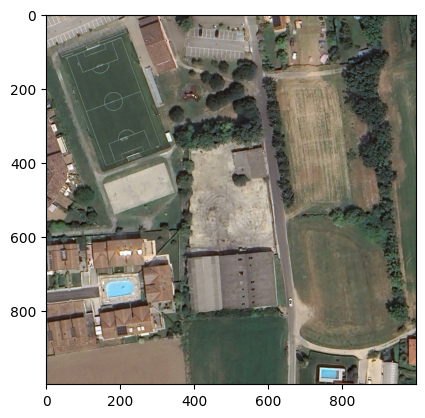

/home/dock/urban_positives/1241/2015.png


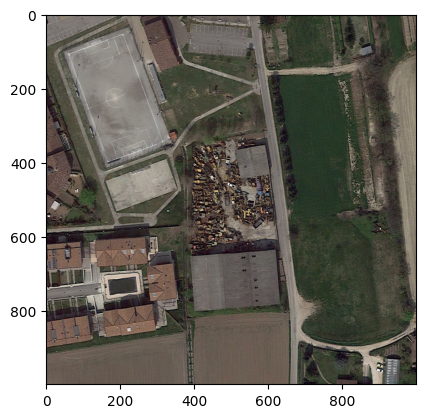

[tensor([6]), tensor([4]), tensor([4]), tensor([4]), tensor([4])]


In [35]:
device = get_device()
model = LULC_Model()
model.load_state_dict(torch.load('/home/dock/Eurosat/lulc-2024-01-16-14-43.pt'))
model.eval()
model = to_device(model, device)
prediction_test = predict_dl_test(test_dl, model)
print(prediction_test)
#final_accuracy(prediction_test, labels)
#preds = [x.item() for x in prediction_test]
#labs = [x.item() for x in labels]
#cm = confusion_matrix(preds, labs)
#cm

In [38]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

def predict_single(image):
   # show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)

In [39]:
print(test_ds)

In [41]:
predict_single(test_ds)

AttributeError: 'urban_positives_Data' object has no attribute 'unsqueeze'

In [53]:
def get_image_list(input_image_path):
        image_list = []
        for file in os.listdir(input_image_path):
            if not file.startswith('.'):
               path = os.path.join(input_image_path, file)
               image_list.append(path)
        return image_list

def load_pil_image(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            plt.imshow(img)
            plt.show()
            return img.convert('RGB')

In [1]:
import cv2
import os

def split_image(input_image_path, output_folder, piece_size):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for root, subfolder_names, files in os.walk(input_image_path):
        for f in files:
            image = cv2.imread(f)
            height, width, _ = image.shape

            rows = height // piece_size
            cols = width // piece_size
            for row in range(rows):
                for col in range(cols):
                    start_x = col * piece_size
                    end_x = (col + 1) * piece_size
                    start_y = row * piece_size
                    end_y = (row + 1) * piece_size

                    piece = image[start_y:end_y, start_x:end_x]

                    piece_filename = f"piece_{row}_{col}.png"
                    piece_path = os.path.join(output_folder, piece_filename)
                    cv2.imwrite(piece_path, piece)

In [2]:
piece_size = 10  
output_folder = '/home/dock/urban_positives/1241/splitted/'
input_image_path = '/home/dock/urban_positives/1241'
split_image(input_image_path, output_folder, piece_size)

[ WARN:0@1.536] global loadsave.cpp:248 findDecoder imread_('2015.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'